In [93]:
import sqlite3
import enum

DB_PATH = "/home/tim/idintfw.db"

con = sqlite3.connect(DB_PATH)
c = con.cursor()
rows = c.execute("SELECT * FROM Runs LEFT JOIN Errors ON Runs.ID=Errors.Run")

class App:
    def __init__(self, sources, sinks, classes, methods, statements, cgsize):
        self.sources = sources
        self.sinks = sinks
        self.classes=classes
        self.methods=methods
        self.statements=statements
        self.cgsize=cgsize
        self.runs = []
        
    def addRun(self, run):
        self.runs.append(run)

class Direction(enum.Enum):
    Forwards = 0
    Backwards = 1
    
class Run:
    def __init__(self, direction, infoflowEdges, aliasEdges, timeElapsed, dataflowTime, 
                 leaks, terminationState, absCountInfoflow, absCountAlias):
        if direction == "FastSolver":
            self.direction = Direction.Forwards
        elif direction == "FastSolverbw":
            self.direction = Direction.Backwards
        else:
            print("ERROR: Unknown direction!")
        self.infoflowEdges = infoflowEdges
        self.aliasEdges = aliasEdges
        self.timeElapsed = timeElapsed
        self.dataflowTime = dataflowTime
        self.leaks = leaks
        self.absCountInfoflow = absCountInfoflow
        self.absCountAlias = absCountAlias
        self.memoryTimeout = terminationState == 2 
        self.timeTimeout = terminationState == 1
        
apps = {}
for row in rows:
    name = row[1]
    
    if not name in apps:
        apps[name] = App(row[16], row[17], row[18], row[19], row[20], row[21])

    # no need to add uncompleted runs
    if row[6] == None or row[6] == -1:
        continue
    # only verify source sink manager when analysis started
    app = apps[name]
    if row[16] != app.sources:
        print("Sources differ for %s: %s to %s" % (name, app.sources, row[16]))
    if row[17] != app.sinks:
        print("Sinks differ for %s: %s to %s" % (name, app.sinks, row[17]))

    app.addRun(Run(row[2], row[22], row[23], row[5], row[6], row[14], row[15], row[12], row[13]))
    

def runToColor(run):
    if run.memoryTimeout:
        return "red"
    elif run.timeTimeout:
        return "orange"
    else:
        return "blue"
    
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylatex.utils import escape_latex 

matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
})


Sources differ for com.cabs.apk: None to 12
Sinks differ for com.cabs.apk: None to 34
Sources differ for com.dywx.larkplayer.apk: 15 to 16
Sources differ for HinKhoj.Dictionary.apk: None to 12
Sinks differ for HinKhoj.Dictionary.apk: None to 26
Sources differ for com.astepanov.mobile.mathforkids.apk: None to 9
Sinks differ for com.astepanov.mobile.mathforkids.apk: None to 3


0.072


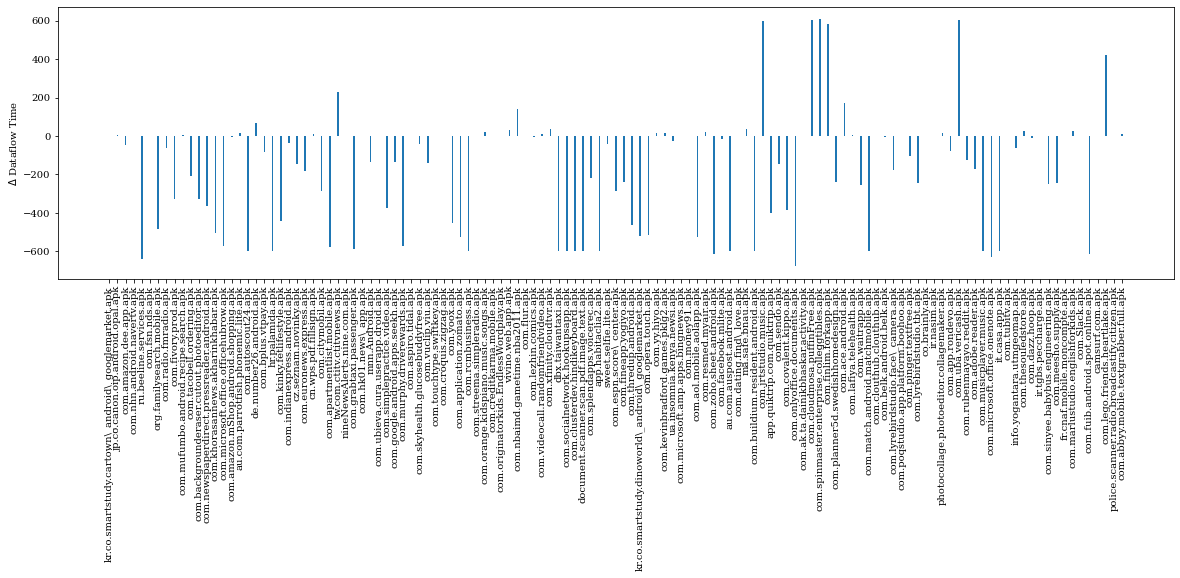

In [94]:
xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []

delta = []
for name, app in apps.items():
    f = 0
    b = 0
    d = 0
    if len(app.runs) == 2:
        for run in app.runs:
            if run.direction == Direction.Forwards:
                datafw.append(run.dataflowTime)
                xfw.append(escape_latex(name))
                cfw.append(runToColor(run))
                d -= run.dataflowTime
            elif run.direction == Direction.Backwards:
                databw.append(run.dataflowTime)
                xbw.append(escape_latex(name))
                cbw.append(runToColor(run))
                d += run.dataflowTime
        delta.append(d)
        
print(d/len(xfw))
            
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ind = np.arange(len(xfw))
width = 0.2
ax.bar(ind, delta, width)
# ax.bar(ind - width/2, datafw, width, color=cfw)
# ax.bar(ind + width/2, databw, width, color=cbw)
ax.set_xticklabels(xfw)
plt.xticks(ind)
ax.set_ylabel("$\\Delta$ Dataflow Time")
_ = plt.xticks(rotation=90)

Text(0.5, 1.0, 'Backwards')

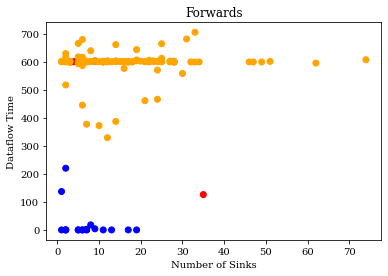

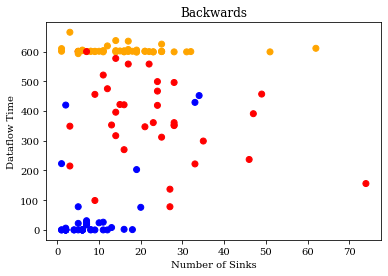

In [88]:
xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []
for name, app in apps.items():
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw.append(app.sinks)
            cfw.append(runToColor(run))
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw.append(app.sinks)
            cbw.append(runToColor(run))
plt.figure()
plt.scatter(xfw, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Dataflow Time")
plt.title("Forwards")

plt.figure()
plt.scatter(xbw, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Dataflow Time")
plt.title("Backwards")

Text(0.5, 1.0, 'Backwards')

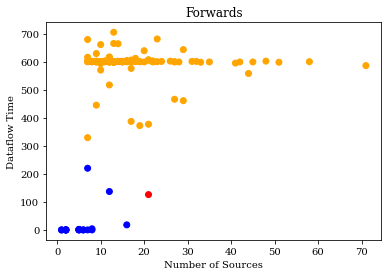

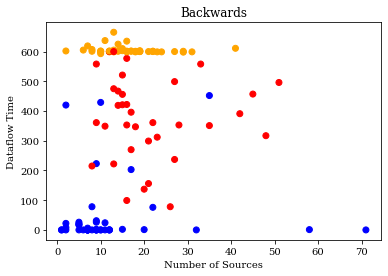

In [91]:
xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []
for name, app in apps.items():
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw.append(app.sources)
            cfw.append(runToColor(run))
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw.append(app.sources)
            cbw.append(runToColor(run))
plt.figure()
plt.scatter(xfw, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Dataflow Time")
plt.title("Forwards")

plt.figure()
plt.scatter(xbw, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Dataflow Time")
plt.title("Backwards")